In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import model_20250901
import simulate
from sklearn.metrics import r2_score
import importlib


c:\Users\haley\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"
random_seed = 2025
r2 = 0.5
n = 1000
dim = 112
coord, true_beta, img_data, y = simulate.simulate_data(n, r2, dim, random_seed)

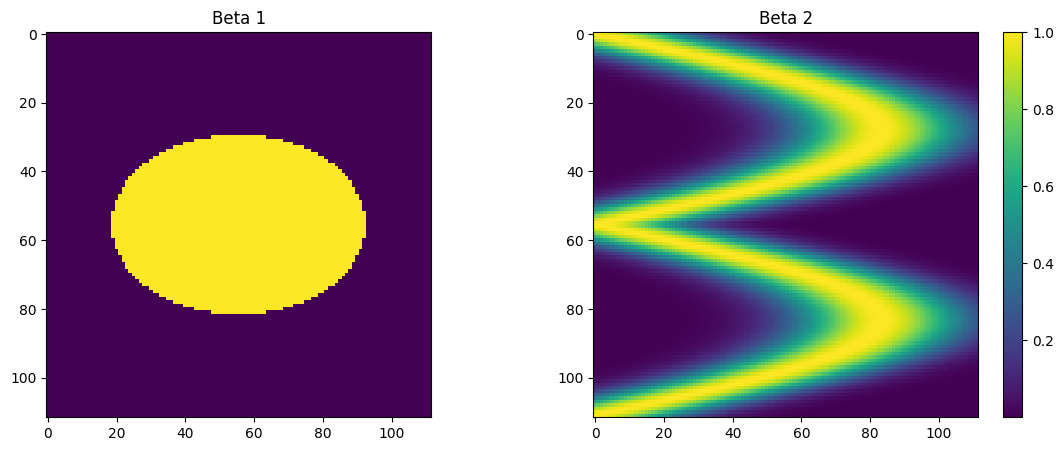

In [3]:
fig, axs = plt.subplots(1, 2, figsize = (14,5))
axs[0].imshow(true_beta[0].reshape(dim, dim))
axs[0].set_title("Beta 1")

cax = axs[1].imshow(true_beta[1].reshape(dim, dim))
axs[1].set_title("Beta 2")

fig.colorbar(cax, ax = axs[1])
plt.show()



In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

image_data_0_reshaped = img_data[0].reshape(n, dim, dim)
image_data_1_reshaped = img_data[1].reshape(n, dim, dim)

stacked_img = np.concatenate([image_data_0_reshaped, image_data_1_reshaped], axis = 1)
stacked_img = stacked_img[:, np.newaxis, :, :]

y = y.reshape(-1, 1)
y_tensor = torch.tensor(y, dtype = torch.float32).to(device)
stacked_img_tensor = torch.tensor(stacked_img, dtype = torch.float32).to(device)

torch.manual_seed(random_seed)
np.random.seed(random_seed)

X_train, X_test, y_train, y_test = train_test_split(stacked_img_tensor, y_tensor, test_size = 0.2, random_state = random_seed)
train_dataset = TensorDataset(X_train, y_train)
test_dataset =  TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [5]:
def train_cnn_model(model_class=model_20250901.CNN_3_3_16_512, 
                    lr=0.001, 
                    weight_decay=0.0, 
                    num_epochs=10, 
                    train_loader=None, 
                    test_loader=None, 
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    verbose=True,
                    plot_results=True):
    """
    Train a CNN model with customizable parameters and track performance metrics.
    
    Args:
        model_class: CNN model class (default: CNN_3_3_16_512)
        lr: Learning rate (default: 0.001)
        weight_decay: L2 regularization (default: 0.0)
        num_epochs: Number of training epochs (default: 50)
        train_loader: Training data loader
        test_loader: Test/validation data loader
        device: Device to run training on
        verbose: Whether to print training progress
        plot_results: Whether to plot learning curves
    
    Returns:
        Dictionary containing training history and best metrics
    """
    # Initialize model, criterion and optimizer
    cnn = model_class().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize lists to track metrics
    train_losses = []
    test_losses = []
    all_train_r2 = []
    all_test_r2 = []
    
    best_epoch = 0
    best_test_loss = float('inf')
    best_test_r2 = -float('inf')

    for epoch in range(num_epochs):
        # --- Training Phase ---
        cnn.train()
        running_loss = 0.0
        y_pred, y_true = [], []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_hat_batch = cnn(X_batch)
            loss = criterion(y_hat_batch, y_batch)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()
                y_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                y_true.extend(y_batch.cpu().numpy().flatten())
        
        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_r2 = r2_score(y_true, y_pred)
        all_train_r2.append(train_r2)
        
        # --- Validation/Test Phase ---
        cnn.eval()
        with torch.no_grad():
            test_pred, test_true = [], []
            test_running_loss = 0.0
            
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_hat_batch = cnn(X_batch)
                loss = criterion(y_hat_batch, y_batch)
                test_running_loss += loss.item()
                test_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                test_true.extend(y_batch.cpu().numpy().flatten())
            
            epoch_test_loss = test_running_loss / len(test_loader)
            test_losses.append(epoch_test_loss)
            test_r2 = r2_score(test_true, test_pred)
            all_test_r2.append(test_r2)
            
            # Update best epoch
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                best_test_r2 = test_r2
                best_epoch = epoch + 1
        
        # Print metrics if verbose
        # if verbose and (epoch + 1) % 1 == 0:
        #     print(f"Epoch {epoch + 1}/{num_epochs}")
        #     print(f"  Train Loss: {epoch_train_loss:.4f} ± {np.std(train_losses):.4f}")
        #     print(f"  Train R²: {train_r2:.4f} ± {np.std(all_train_r2):.4f}")
        #     print(f"  Test Loss: {epoch_test_loss:.4f} ± {np.std(test_losses):.4f}")
        #     print(f"  Test R²: {test_r2:.4f} ± {np.std(all_test_r2):.4f}\n")

    # Final summary
    if verbose:
        print(f"\n=== {model_class.__name__} Training Summary ===")
        print(f"Best Epoch: {best_epoch}")
        print(f"Best Test Loss: {best_test_loss:.4f}")
        print(f"Corresponding Test R²: {best_test_r2:.4f}")
        print(f"Final Train Loss: {train_losses[-1]:.4f} ± {np.std(train_losses):.4f}")
        print(f"Final Train R²: {all_train_r2[-1]:.4f} ± {np.std(all_train_r2):.4f}")
        print(f"Final Test Loss: {test_losses[-1]:.4f} ± {np.std(test_losses):.4f}")
        print(f"Final Test R²: {all_test_r2[-1]:.4f} ± {np.std(all_test_r2):.4f}")

    # Plot results if requested
    if plot_results:
        plt.figure(figsize=(12, 5))

        # Plot Losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title(f'{model_class.__name__} Training & Test Loss')
        plt.legend()

        # Plot R² Scores
        plt.subplot(1, 2, 2)
        plt.plot(all_train_r2, label='Train R²')
        plt.plot(all_test_r2, label='Test R²')
        plt.xlabel('Epoch')
        plt.ylabel('R² Score')
        plt.title(f'{model_class.__name__} R² Scores')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return {
        'model': cnn,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_r2_scores': all_train_r2,
        'test_r2_scores': all_test_r2,
        'best_epoch': best_epoch,
        'best_test_loss': best_test_loss,
        'best_test_r2': best_test_r2,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'final_train_r2': all_train_r2[-1],
        'final_test_r2': all_test_r2[-1]
    }

# Example usage:
# results = train_cnn_model(model_class=model.CNN2d512,
#                         lr=0.0001,
#                         weight_decay=0.01,
#                         num_epochs=100,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [6]:
import model_20250901
importlib.reload(model_20250901)      # Force-reload the module
from model_20250901 import CNN_3_3_16_512, CNN_2_2_16_512, CNN_3_3_16_256 , CNN_2_2_16_256 , CNN_3_3_8_256, CNN_2_2_8_256, CNN_3_3_8_128, CNN_2_2_8_128, CNN_3_3_16_128, CNN_2_2_16_128       # Import the updated class


=== CNN_3_3_16_512 Training Summary ===
Best Epoch: 3
Best Test Loss: 109.4499
Corresponding Test R²: 0.2979
Final Train Loss: 50.2686 ± 24.3081
Final Train R²: 0.6761 ± 0.1566
Final Test Loss: 129.4600 ± 80.3306
Final Test R²: 0.1827 ± 0.5259


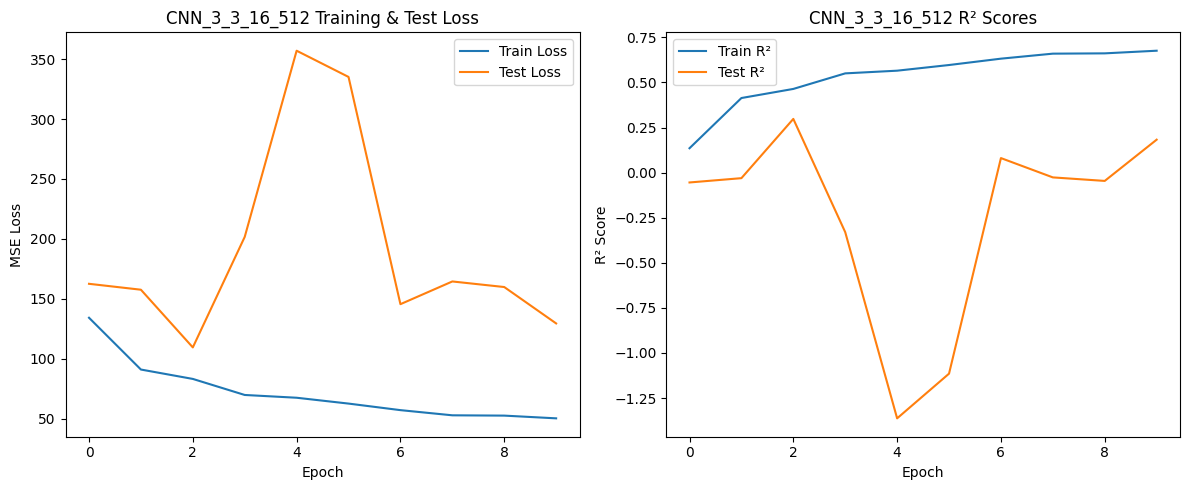

In [7]:
# session 1
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_512 Training Summary ===
Best Epoch: 10
Best Test Loss: 107.8354
Corresponding Test R²: 0.3062
Final Train Loss: 96.8377 ± 19.3732
Final Train R²: 0.3760 ± 0.1248
Final Test Loss: 107.8354 ± 17.7866
Final Test R²: 0.3062 ± 0.1170


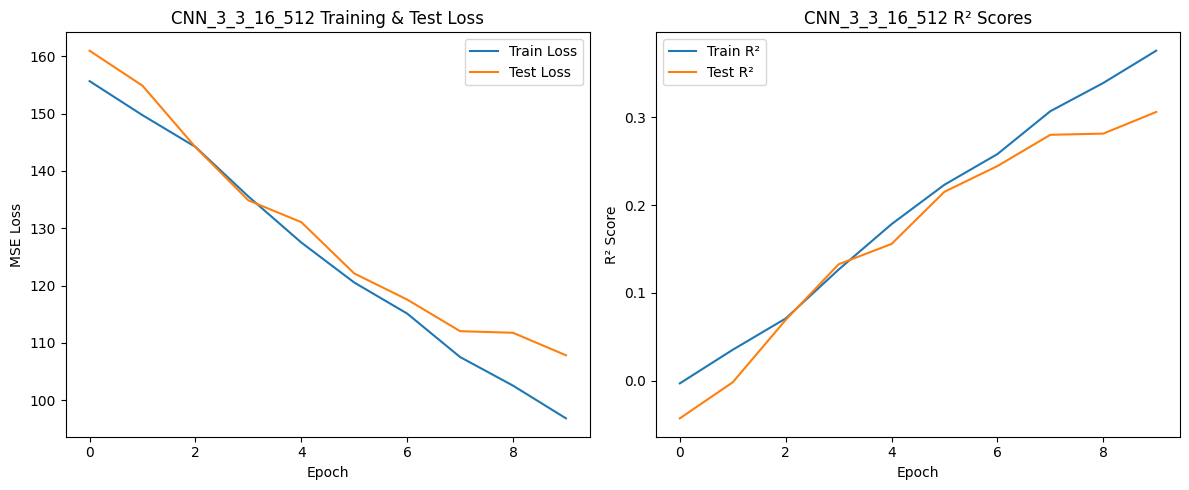

In [8]:
# session 2 
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_512 Training Summary ===
Best Epoch: 9
Best Test Loss: 98.1057
Corresponding Test R²: 0.3707
Final Train Loss: 82.1093 ± 23.7056
Final Train R²: 0.4709 ± 0.1528
Final Test Loss: 125.8304 ± 60.6417
Final Test R²: 0.1954 ± 0.3841


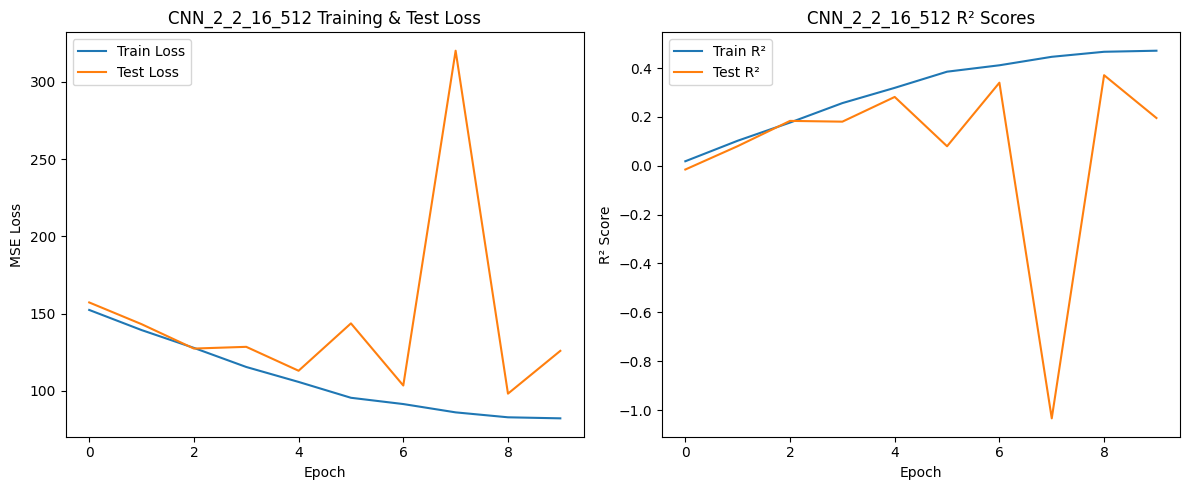

In [9]:
# session 3 
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_512 Training Summary ===
Best Epoch: 10
Best Test Loss: 143.9861
Corresponding Test R²: 0.0728
Final Train Loss: 141.7831 ± 4.9984
Final Train R²: 0.0864 ± 0.0322
Final Test Loss: 143.9861 ± 4.7462
Final Test R²: 0.0728 ± 0.0322


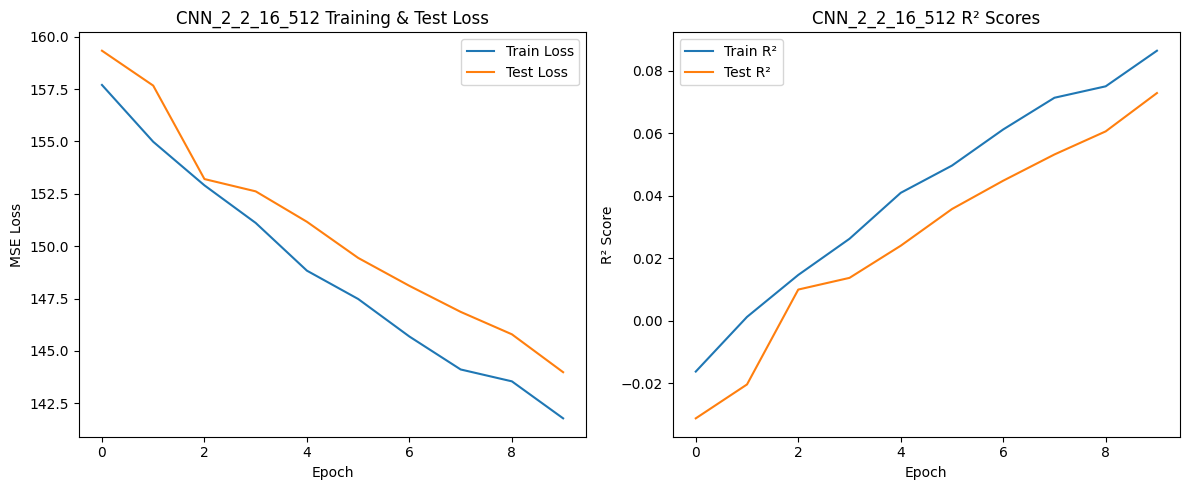

In [10]:
# session 4
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_256 Training Summary ===
Best Epoch: 4
Best Test Loss: 101.0811
Corresponding Test R²: 0.3483
Final Train Loss: 58.6463 ± 26.6970
Final Train R²: 0.6221 ± 0.1720
Final Test Loss: 223.0327 ± 37.7403
Final Test R²: -0.4452 ± 0.2486


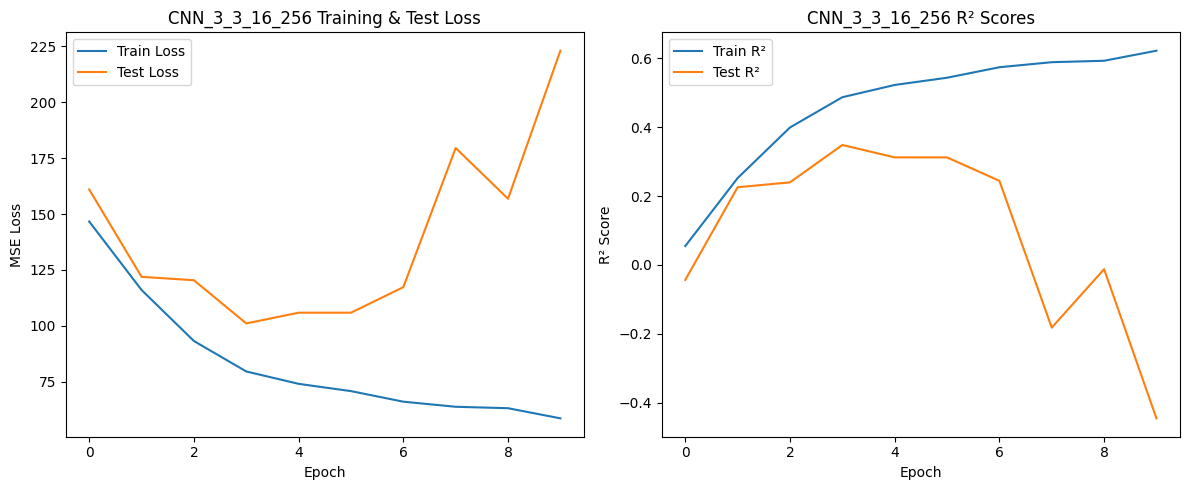

In [11]:
# session 5
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_256 Training Summary ===
Best Epoch: 10
Best Test Loss: 122.2451
Corresponding Test R²: 0.2129
Final Train Loss: 121.2648 ± 11.2929
Final Train R²: 0.2186 ± 0.0728
Final Test Loss: 122.2451 ± 11.4726
Final Test R²: 0.2129 ± 0.0750


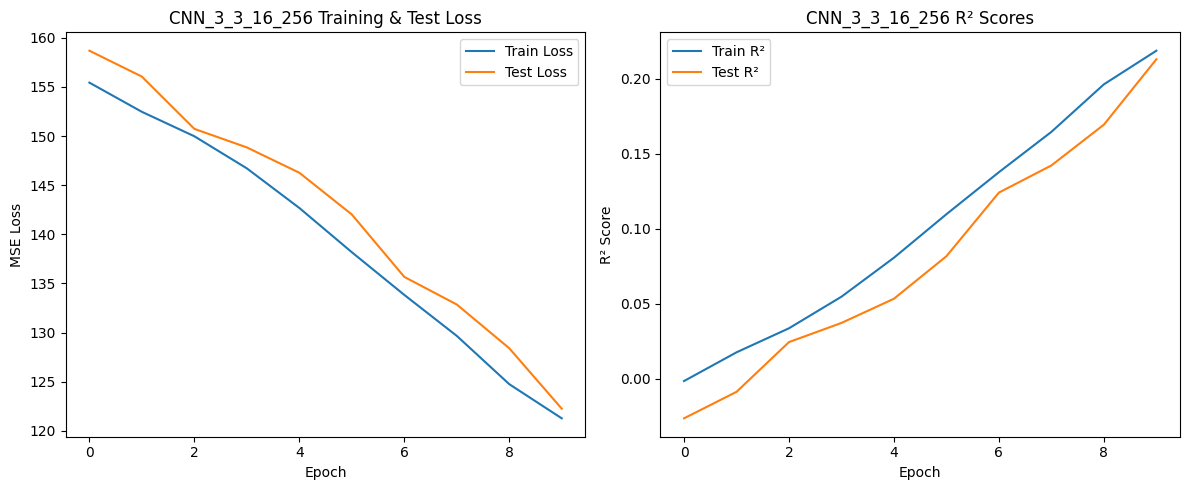

In [12]:
# session 6

results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_256 Training Summary ===
Best Epoch: 9
Best Test Loss: 109.9777
Corresponding Test R²: 0.3044
Final Train Loss: 91.7242 ± 19.3493
Final Train R²: 0.4089 ± 0.1247
Final Test Loss: 123.9166 ± 14.4645
Final Test R²: 0.2090 ± 0.0982


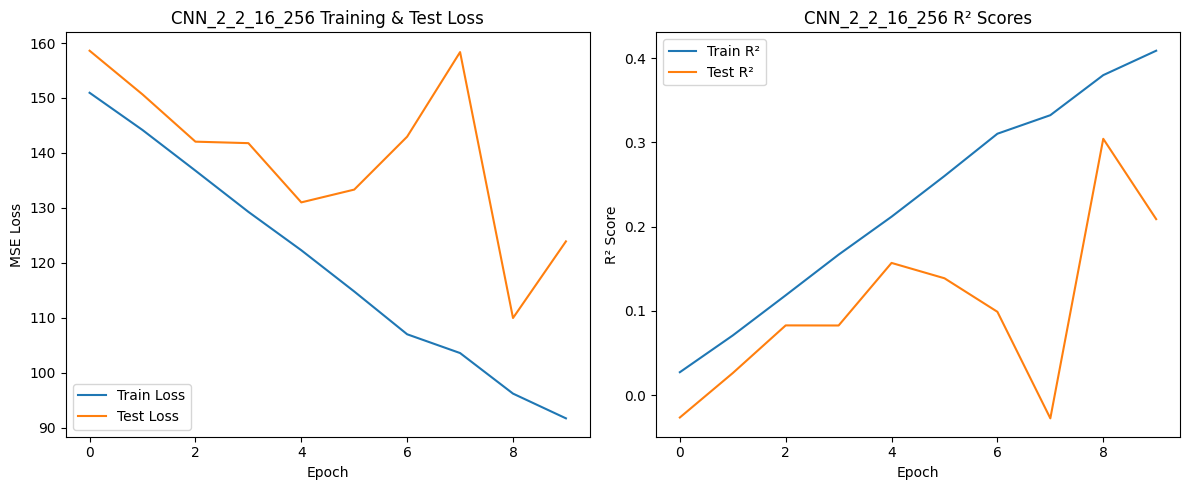

In [13]:
# session 7
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_256 Training Summary ===
Best Epoch: 10
Best Test Loss: 149.3759
Corresponding Test R²: 0.0350
Final Train Loss: 146.5165 ± 3.2376
Final Train R²: 0.0559 ± 0.0209
Final Test Loss: 149.3759 ± 3.0765
Final Test R²: 0.0350 ± 0.0207


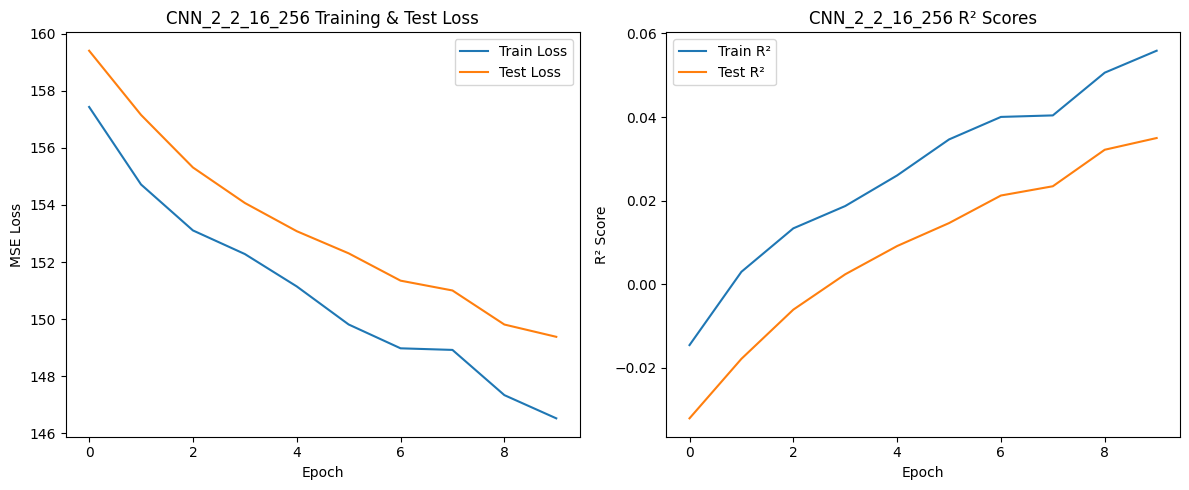

In [14]:
# session 8
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_512 Training Summary ===
Best Epoch: 3
Best Test Loss: 121.4409
Corresponding Test R²: 0.2053
Final Train Loss: 45.3272 ± 25.6624
Final Train R²: 0.7079 ± 0.1654
Final Test Loss: 430.7720 ± 212.5308
Final Test R²: -1.8546 ± 1.3572


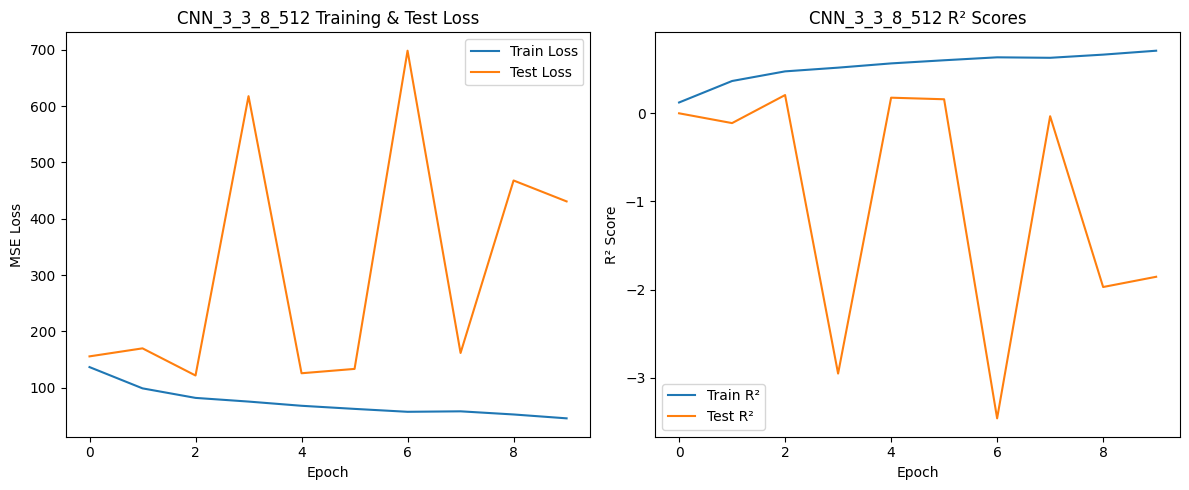

In [15]:
# session 9

results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_512 Training Summary ===
Best Epoch: 10
Best Test Loss: 106.3387
Corresponding Test R²: 0.3192
Final Train Loss: 99.3312 ± 18.8790
Final Train R²: 0.3599 ± 0.1217
Final Test Loss: 106.3387 ± 17.3703
Final Test R²: 0.3192 ± 0.1154


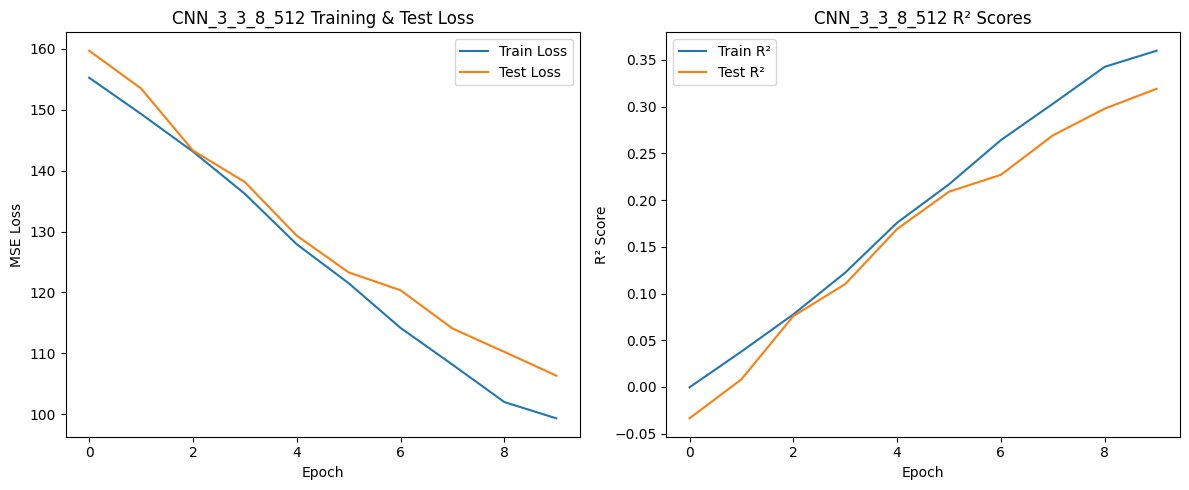

In [16]:
# session 10

results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_512 Training Summary ===
Best Epoch: 7
Best Test Loss: 102.5112
Corresponding Test R²: 0.3527
Final Train Loss: 87.9019 ± 20.4632
Final Train R²: 0.4336 ± 0.1319
Final Test Loss: 201.0983 ± 41.7816
Final Test R²: -0.3265 ± 0.2869


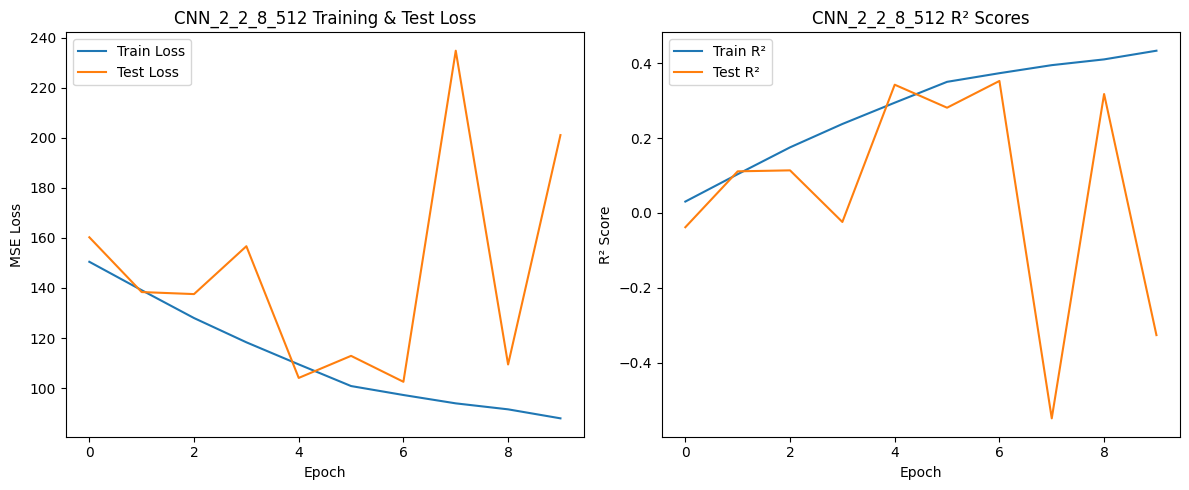

In [17]:
# session 11
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_512 Training Summary ===
Best Epoch: 10
Best Test Loss: 144.6687
Corresponding Test R²: 0.0694
Final Train Loss: 144.3041 ± 4.2404
Final Train R²: 0.0701 ± 0.0273
Final Test Loss: 144.6687 ± 4.4894
Final Test R²: 0.0694 ± 0.0308


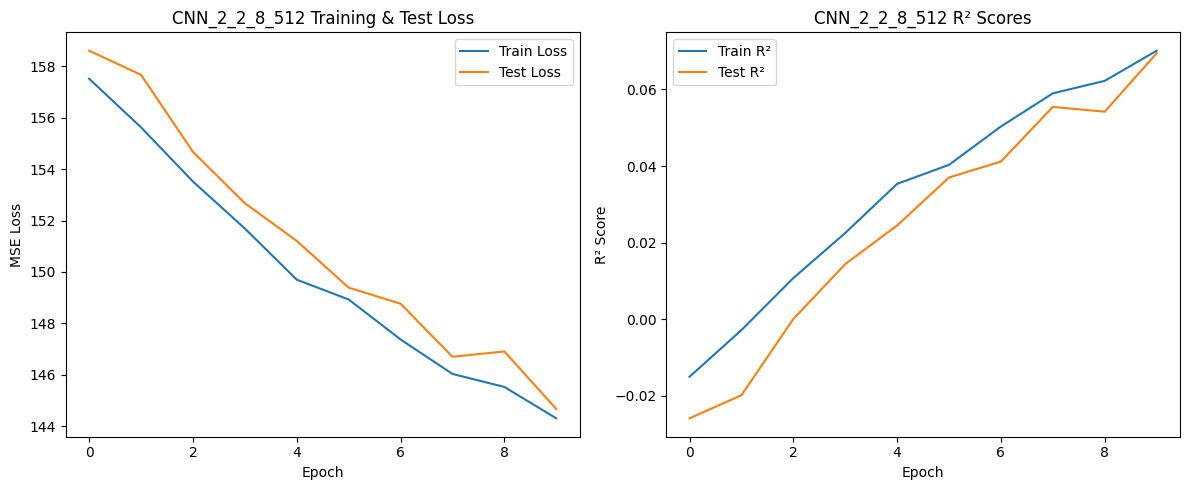

In [18]:
# session 12
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_256 Training Summary ===
Best Epoch: 9
Best Test Loss: 133.1715
Corresponding Test R²: 0.1535
Final Train Loss: 67.1948 ± 26.4538
Final Train R²: 0.5670 ± 0.1705
Final Test Loss: 197.3665 ± 97.5704
Final Test R²: -0.3081 ± 0.6565


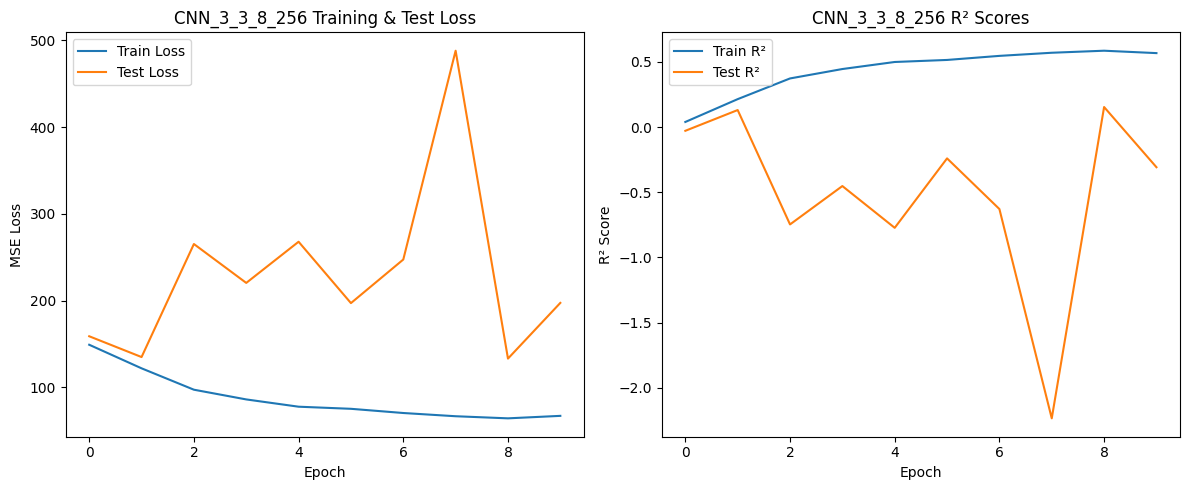

In [19]:
# session 13
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_256 Training Summary ===
Best Epoch: 10
Best Test Loss: 125.8228
Corresponding Test R²: 0.1919
Final Train Loss: 125.5596 ± 10.1098
Final Train R²: 0.1909 ± 0.0651
Final Test Loss: 125.8228 ± 10.7524
Final Test R²: 0.1919 ± 0.0713


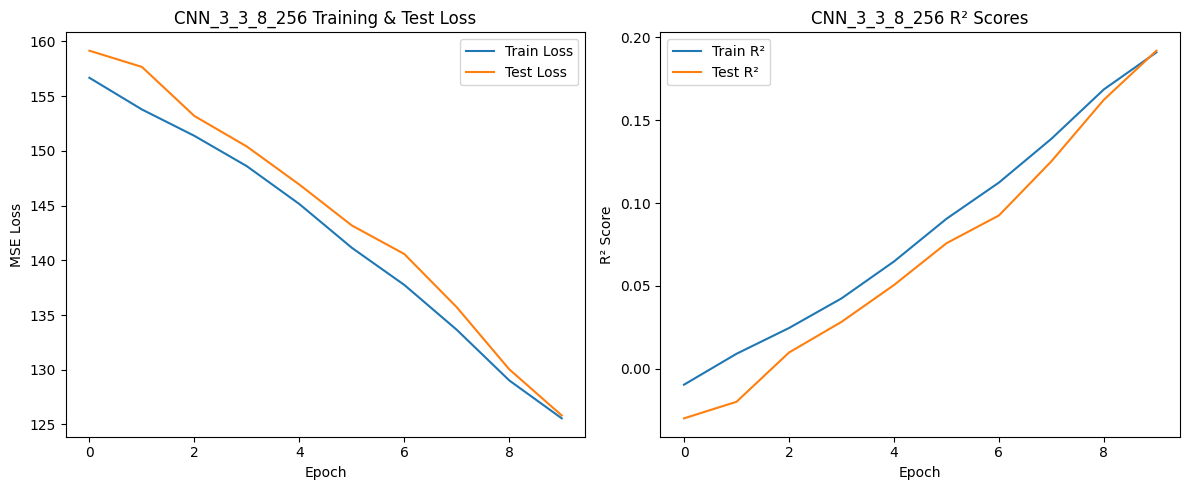

In [20]:
# session 14
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_256 Training Summary ===
Best Epoch: 8
Best Test Loss: 118.3469
Corresponding Test R²: 0.2434
Final Train Loss: 103.4617 ± 17.0998
Final Train R²: 0.3333 ± 0.1102
Final Test Loss: 142.8818 ± 64.7647
Final Test R²: 0.0706 ± 0.4362


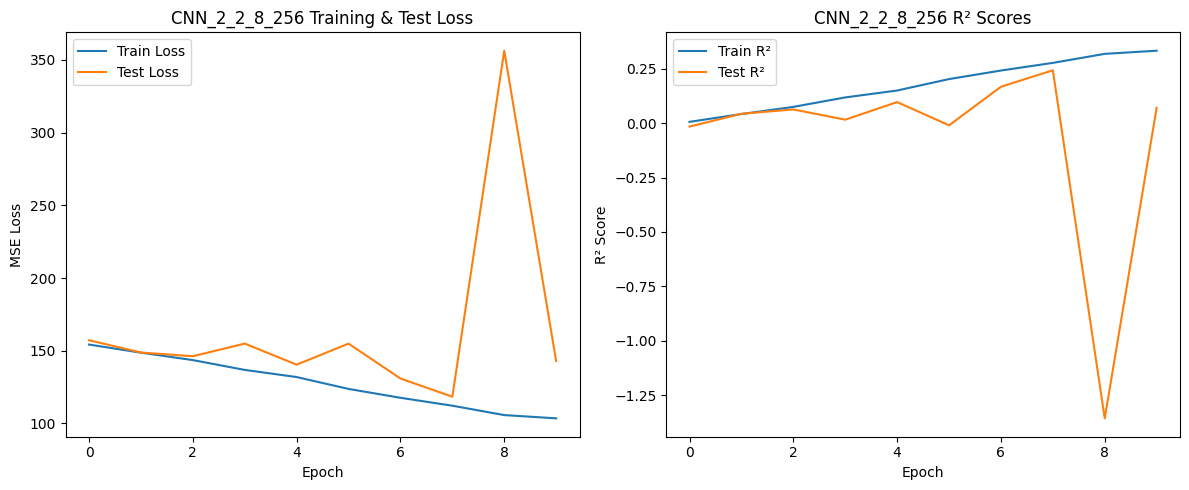

In [21]:
# session 15
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_256 Training Summary ===
Best Epoch: 10
Best Test Loss: 150.8653
Corresponding Test R²: 0.0254
Final Train Loss: 149.1469 ± 2.1343
Final Train R²: 0.0389 ± 0.0138
Final Test Loss: 150.8653 ± 2.5133
Final Test R²: 0.0254 ± 0.0167


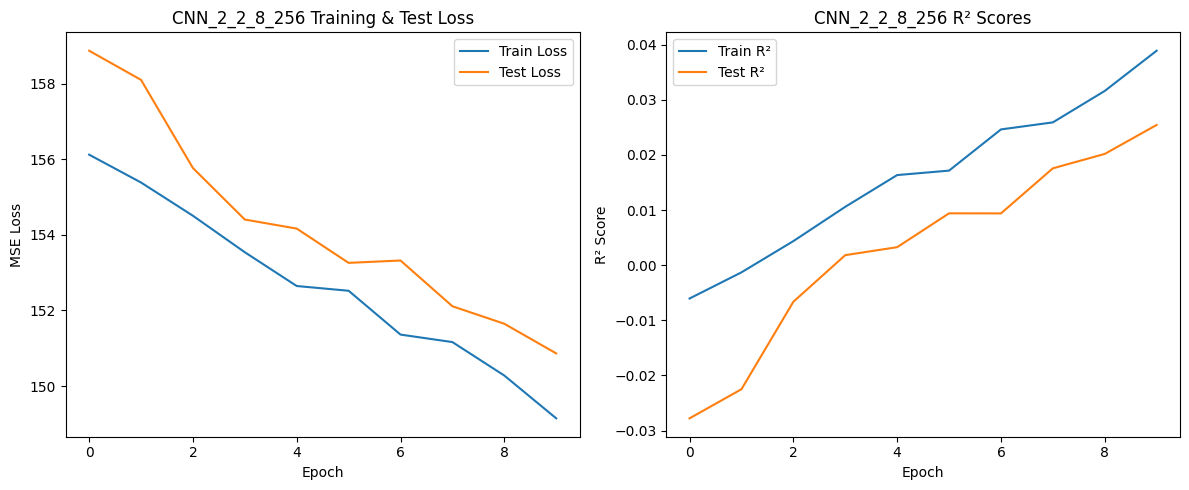

In [22]:
# session 16
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_128 Training Summary ===
Best Epoch: 10
Best Test Loss: 110.3558
Corresponding Test R²: 0.2915
Final Train Loss: 72.2560 ± 26.5003
Final Train R²: 0.5344 ± 0.1708
Final Test Loss: 110.3558 ± 179.5523
Final Test R²: 0.2915 ± 1.1481


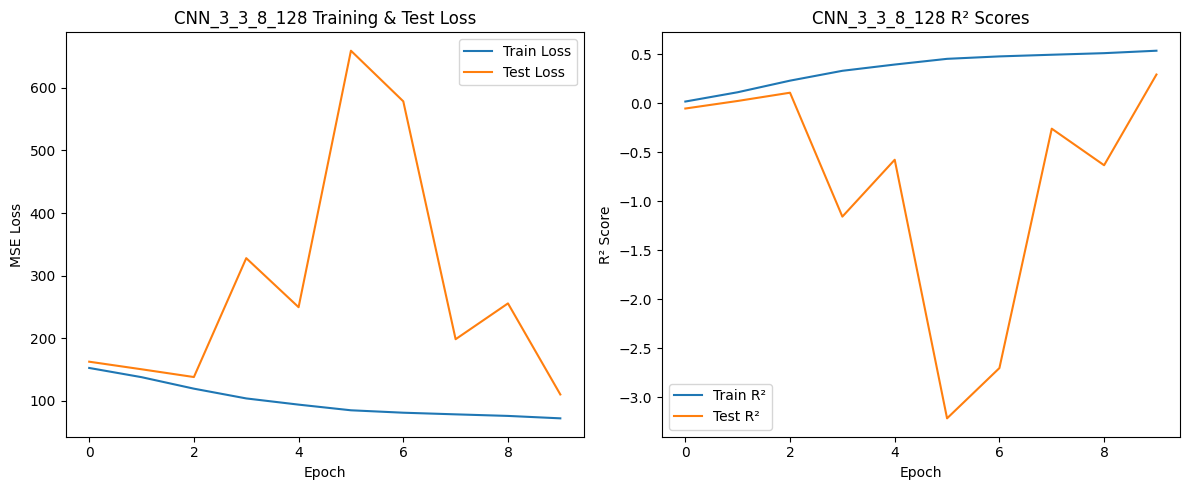

In [23]:
# session 17
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_8_128 Training Summary ===
Best Epoch: 10
Best Test Loss: 147.0325
Corresponding Test R²: 0.0499
Final Train Loss: 142.6765 ± 4.2930
Final Train R²: 0.0806 ± 0.0277
Final Test Loss: 147.0325 ± 4.1457
Final Test R²: 0.0499 ± 0.0273


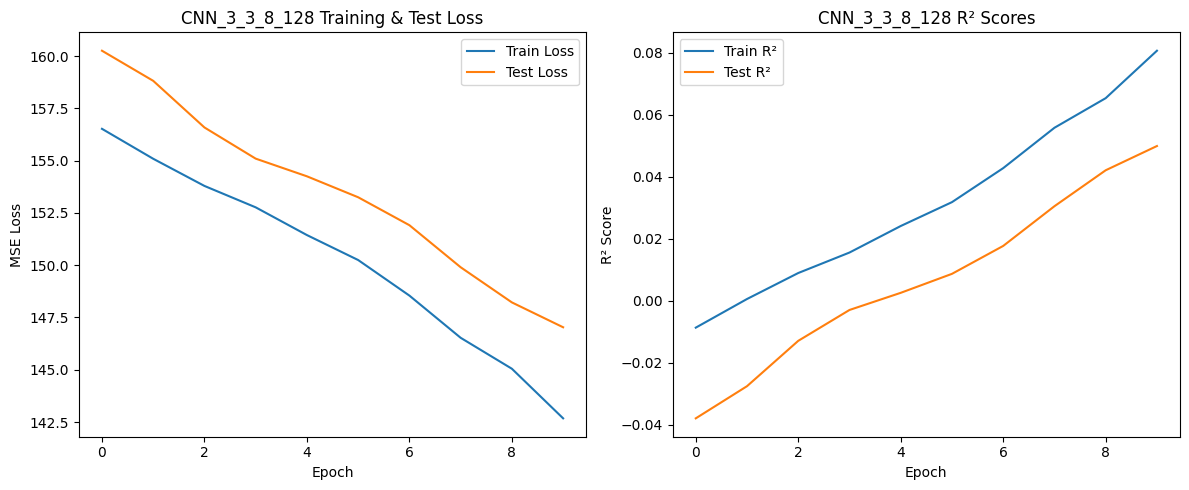

In [24]:
# session 18
results = train_cnn_model(model_class=model_20250901.CNN_3_3_8_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_128 Training Summary ===
Best Epoch: 10
Best Test Loss: 119.7158
Corresponding Test R²: 0.2378
Final Train Loss: 119.0189 ± 11.8501
Final Train R²: 0.2331 ± 0.0764
Final Test Loss: 119.7158 ± 10.4386
Final Test R²: 0.2378 ± 0.0701


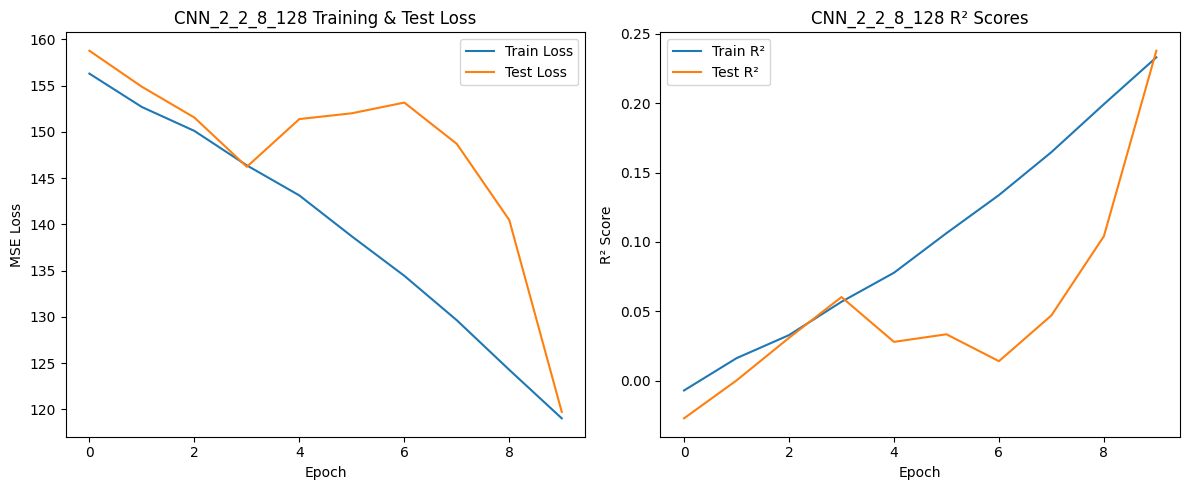

In [25]:
# session 19
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_8_128 Training Summary ===
Best Epoch: 10
Best Test Loss: 155.2081
Corresponding Test R²: -0.0037
Final Train Loss: 153.2219 ± 1.6065
Final Train R²: 0.0127 ± 0.0104
Final Test Loss: 155.2081 ± 1.6360
Final Test R²: -0.0037 ± 0.0113


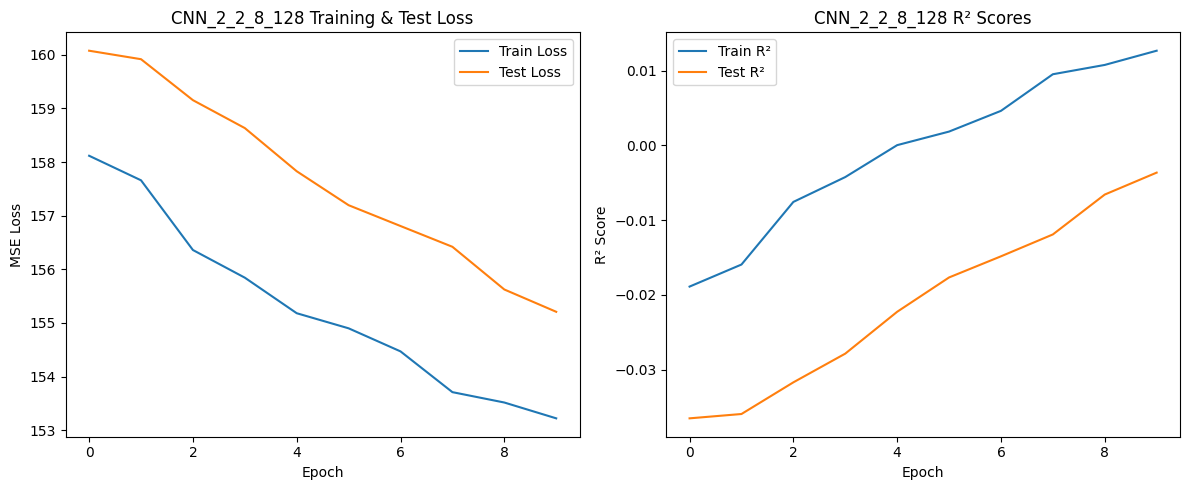

In [26]:
# session 20
results = train_cnn_model(model_class=model_20250901.CNN_2_2_8_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_128 Training Summary ===
Best Epoch: 8
Best Test Loss: 107.2620
Corresponding Test R²: 0.3204
Final Train Loss: 68.1946 ± 27.8141
Final Train R²: 0.5606 ± 0.1792
Final Test Loss: 171.5224 ± 21.2615
Final Test R²: -0.0882 ± 0.1391


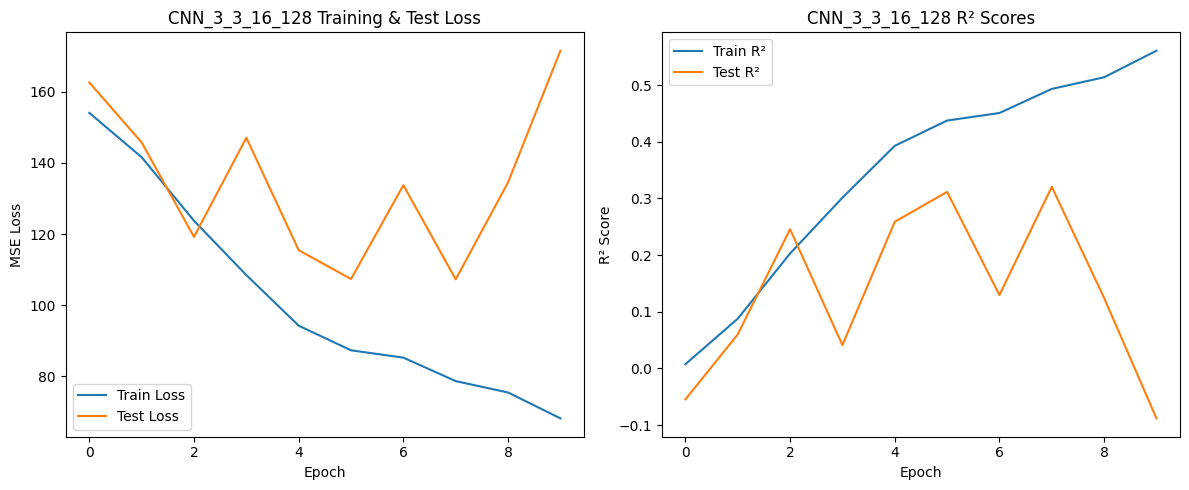

In [27]:
# session 21
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_3_3_16_128 Training Summary ===
Best Epoch: 10
Best Test Loss: 143.3752
Corresponding Test R²: 0.0759
Final Train Loss: 137.0076 ± 6.2535
Final Train R²: 0.1171 ± 0.0403
Final Test Loss: 143.3752 ± 5.2139
Final Test R²: 0.0759 ± 0.0351


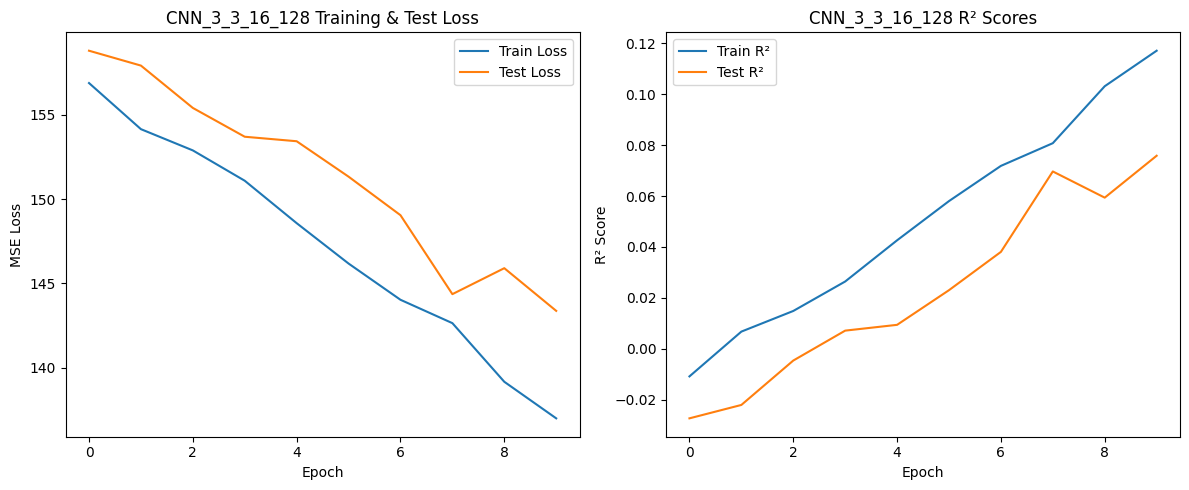

In [28]:
# session 22
results = train_cnn_model(model_class=model_20250901.CNN_3_3_16_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_128 Training Summary ===
Best Epoch: 5
Best Test Loss: 133.5871
Corresponding Test R²: 0.1470
Final Train Loss: 100.8457 ± 16.7770
Final Train R²: 0.3502 ± 0.1081
Final Test Loss: 252.6926 ± 31.8579
Final Test R²: -0.6709 ± 0.2180


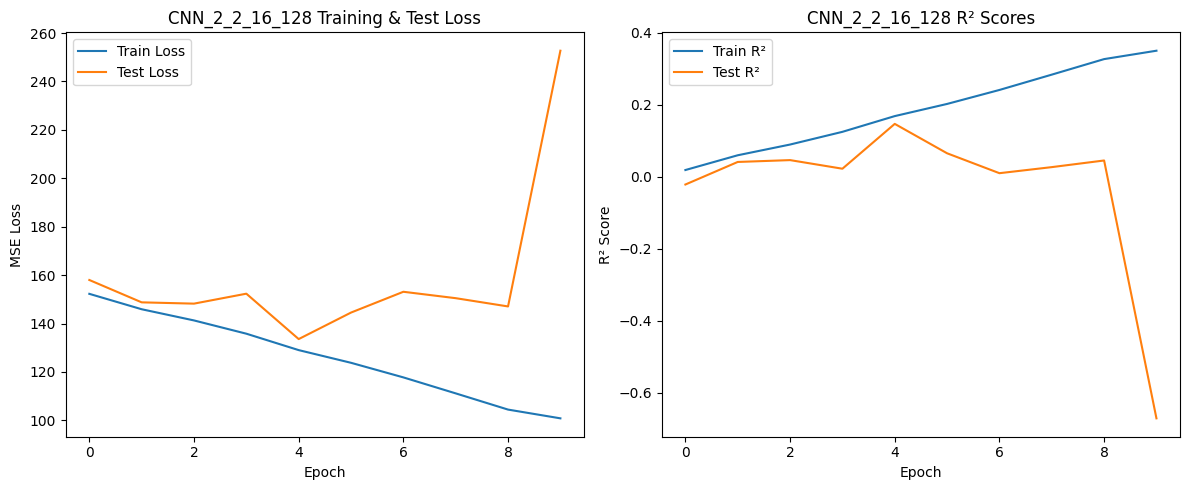

In [29]:
# session 23
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== CNN_2_2_16_128 Training Summary ===
Best Epoch: 10
Best Test Loss: 148.0669
Corresponding Test R²: 0.0453
Final Train Loss: 147.6038 ± 2.3256
Final Train R²: 0.0489 ± 0.0150
Final Test Loss: 148.0669 ± 3.7282
Final Test R²: 0.0453 ± 0.0254


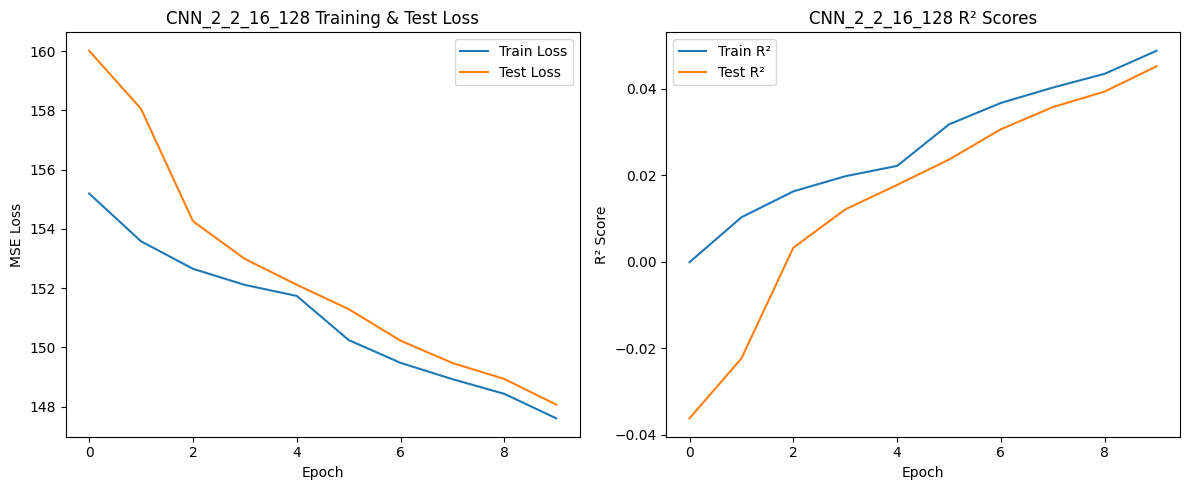

In [30]:
# session 24
results = train_cnn_model(model_class=model_20250901.CNN_2_2_16_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=10,
                        train_loader=train_loader,
                        test_loader=test_loader)